# 2D (x-y) field generation: resolution sensitivity

In [1]:
import os
#from tqdm import tqdm
#from itertools import product

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import xrft

#from gptide import cov
#from gptide import GPtideScipy
#from gptide import stats as gpstats

import nwatools.stats as st

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
#data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"
#store = True

ModuleNotFoundError: No module named 'nwatools'

In [ ]:
from dask.distributed import Client
client = Client()
client

## Generate velocity fields

The different flow formulations considered are:

1. direct velocity field generation: $u$ and $v$ specified independantly and with separable autocorrelations (x/y/t).
2. streamfunction and potential field generation: $u=-\partial_y \psi + \partial_x \phi$ and $v=\partial_x \psi + \partial_y \phi$, where $\psi$ and $\phi$ are independent fields with separable autocorrelations.

**Points addressed:**

- kinetic energy spectral slopes need to match general expectation of isotropic wavenumber spectral slope between -3 and -2.
- separability implies non-isotropic spatial spectra and weird deformation (e.g. vorticity, divergence) fields, we opt for isotropic formulation

**Points to potentially in the future address:**

- $\psi$ $\phi$ correlations have been considered in the past, see mention of spirality in [Wang and Buhler 2021]
- could we make the problem 2D periodic?

**Note:** Link Matern parameters ($\nu$, n=1) to spectral slope $s$ ($k^{-s}$): $s=2\nu+n$.

In [ ]:
#### 
# Input parameters

# signal characteristics
U = .1     # amplitude m/s (will be rescale for streamfunction/potential amplitudes) - reference case
λx = 100   # km
λy = 100   # km

# velocity field formulation
#kind = "uv"
kind, pp_ratio = "pp", 0.

# covariance mode
#Cmodel=("matern2_iso", "matern12")
Cmodel=("matern32_iso", "matern12")

In [ ]:
### velocity field formulation

if kind=="uv":
    # u-v formulation
    η = U
    amplitudes = (η, η)
    suffix = kind
elif kind=="pp":
    # psi-phi field formulation
    #λ = np.sqrt(λx**2 + λy**2)
    λ = λx
    if "matern32" in Cmodel[0]:
        ν = 3/2
    else:
        assert False, "implement scaling factor"
    η = np.sqrt((ν-1)/ν)*U*λ
    amplitudes = (η*(1-pp_ratio), η*pp_ratio)
    #scale = λ*0.5
    #amplitudes = (scale * amplitudes[0], scale * amplitudes[1])

In [ ]:
# assemble prefix and parameters for storage

#suffix = "_".join([Cmodel[0], Cmodel[1],kind, f"r{pp_ratio}"])
suffix = "_".join([Cmodel[0], Cmodel[1], kind, f"r{pp_ratio}_u{U}"])

params = dict(
    U = U,
    eta = η,
    lambda_x = λx,
    lambda_y = λy, 
    lambda_t = λt,
    cov_x = Cmodel[0],
    cov_y = Cmodel[0],
    cov_t = Cmodel[1],
    kind = kind,
    amplitude0 = amplitudes[0],
    amplitude1 = amplitudes[1],
    pp_ratio = pp_ratio,
    noise = noise,
)

print(suffix)
params

### start assembling covariances

In [ ]:
# Grid parameters: size, spacing
Nx, dx = 1000, 1.  # km
Ny, dy = 1000, 1.  # km

# rescale grid parameters for some models
if "iso" in Cmodel[0]:
    factor = 10
    Nx //= factor
    Ny //= factor
    dx *= factor  # km
    dy *= factor  # km

In [6]:
# actually generate covariances

# dummy time covariances

C, X, N, isotropy = st.generate_covariances(Cmodel, (Nx, Ny, Nt), (dx, dy, dt), (λx, λy, λt))

# add jitter on diagonal or get at cholesky: LinAlgError: Matrix is not positive definite
jitter = 1e-6
if len(C)==2:
    C = C[0], C[1]+jitter*np.eye(*C[1].shape)
elif len(C)==3:
    C = C[0], C[1], C[2]+jitter*np.eye(*C[2].shape)

Covariance models: space=matern32_iso , time=matern12


## sample generation

In [8]:
#ds = st.generate_uv(kind, N, C, X, amplitudes, noise, time=False, isotropy=isotropy) # dev
ds = st.generate_uv(kind, N, C, X, amplitudes, noise, time=True, isotropy=isotropy) # could use seed kwarg here
ds.attrs.update(**params)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/dask/array/routines.py:328: PerformanceWarning: Increasing number of chunks by factor of 480
  intermediate = blockwise(
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/dask/array/routines.py:328: PerformanceWarning: Increasing number of chunks by factor of 480
  intermediate = blockwise(


In [10]:
if store:
    ds.to_zarr(os.path.join(data_dir, "3D_"+suffix+"_flow.zarr"), mode="w")

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


### reload and plot

In [6]:
ds = xr.open_zarr(os.path.join(data_dir, "3D_"+suffix+"_flow.zarr"), decode_times=False)

In [12]:
# verifies flow amplitude on full dataset
float(ds["U"].std()), float(ds["V"].std())

(0.08956340332080236, 0.08807085233727246)

In [13]:
# on snapshot
_ds = ds.isel(time=0).persist()
float(_ds["U"].std()), float(_ds["V"].std())

(0.0855110227777531, 0.0911826749916769)

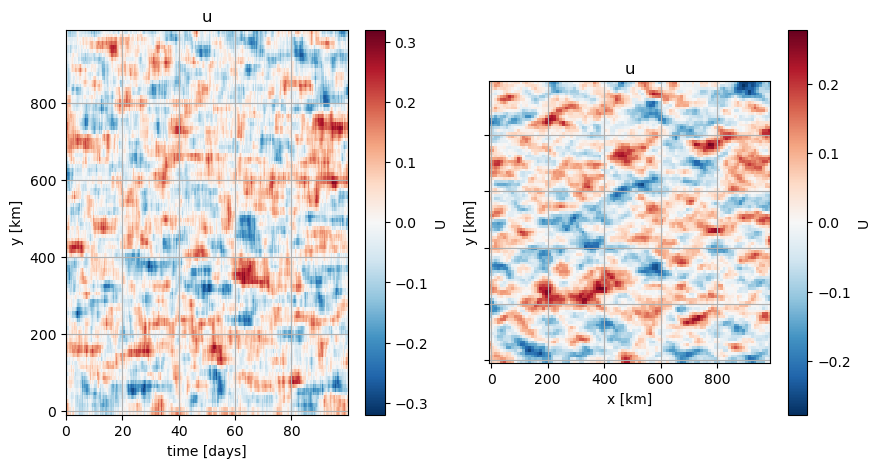

In [14]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)

ax = axes[0]
ds.U.isel(x=ds.x.size//2).plot(ax=ax, x="time", y="y")
ax.grid()
ax.set_title("u")

ax = axes[1]
ds.U.isel(time=0).plot(ax=ax, x="x", y="y")
ax.grid()
ax.set_title("u")
ax.set_aspect("equal")

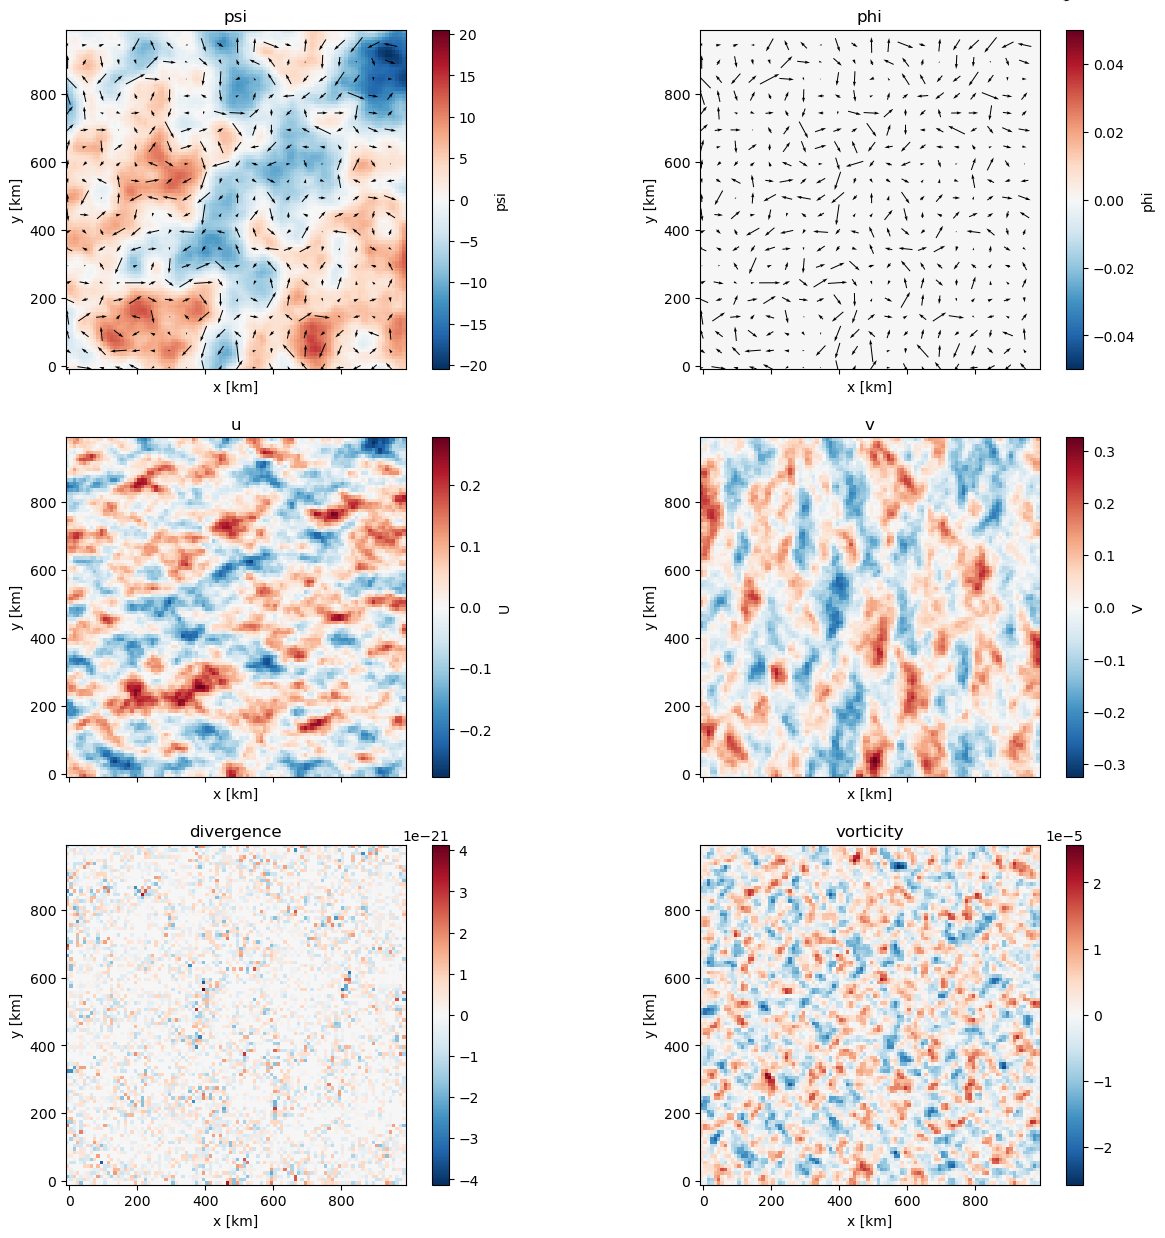

In [15]:
st.plot_snapshot(_ds, darrow=5);

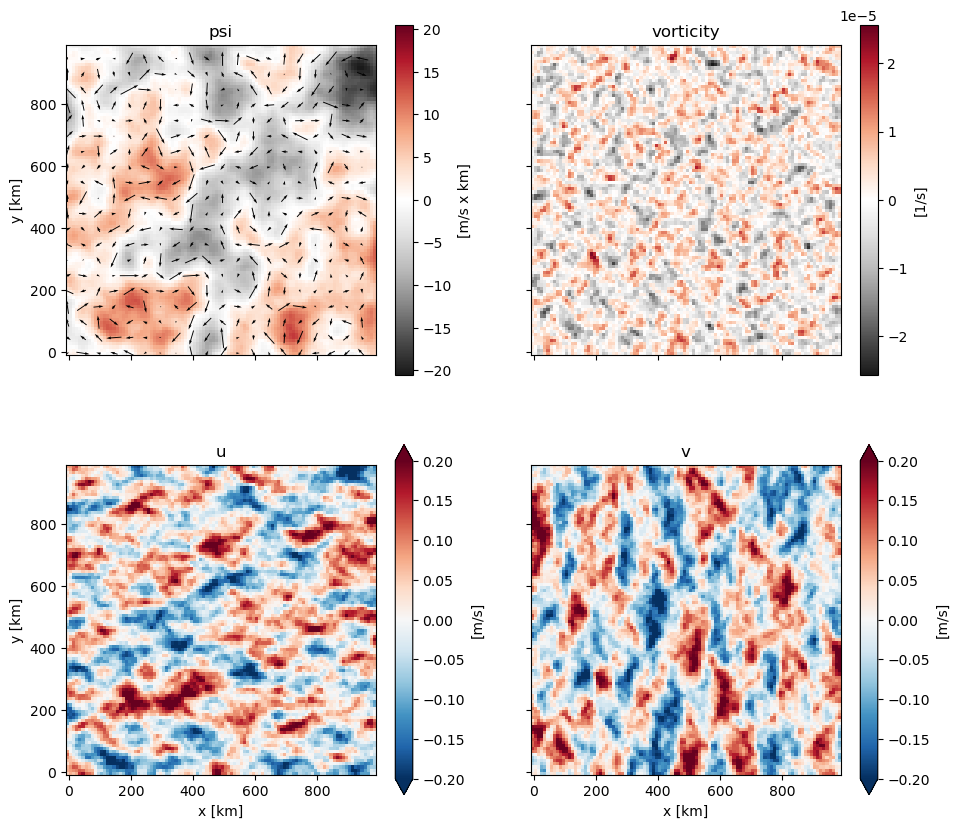

In [16]:
def plot_snapshot_vortical(ds, darrow=20):
    
    fig, axes = plt.subplots(2,2,figsize=(11,10), sharex=True, sharey=True)
    
    dsa = ds.isel(x=slice(0,None,darrow), y=slice(0,None,darrow))

    ax = axes[0, 0]
    ds.psi.plot(ax=ax, cmap="RdGy_r", cbar_kwargs={'label': "[m/s x km]"})
    dsa.plot.quiver("x", "y", "U", "V", ax=ax, add_guide = False)
    ax.set_aspect("equal")
    ax.set_title("psi")
    ax.set_xlabel("")
    
    ## velocities
    u_scale = U*2

    ax = axes[1, 0]
    ds.U.plot(ax=ax, cmap="RdBu_r", cbar_kwargs={'label': "[m/s]"}, vmax=u_scale)
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("u")
    
    ax = axes[1, 1]
    ds.V.plot(ax=ax, cmap="RdBu_r", cbar_kwargs={'label': "[m/s]"}, vmax=u_scale)
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("v")
    ax.set_ylabel("")
    
    ##
    vorticity = ds.V.differentiate("x")/1e3 - ds.U.differentiate("y")/1e3
    
    ax = axes[0, 1]
    vorticity.plot(ax=ax, cmap="RdGy_r", cbar_kwargs={'label': "[1/s]"})
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("vorticity")    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    return fig, axes

plot_snapshot_vortical(_ds, darrow=5);

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray (freq_r: 17)>
dask.array<getitem, shape=(17,), dtype=float64, chunksize=(17,), chunktype=numpy.ndarray>
Coordinates:
    time     float64 -0.02083
  * freq_r   (freq_r) float64 0.001874 0.0044 0.00716 ... 0.04385 0.04669


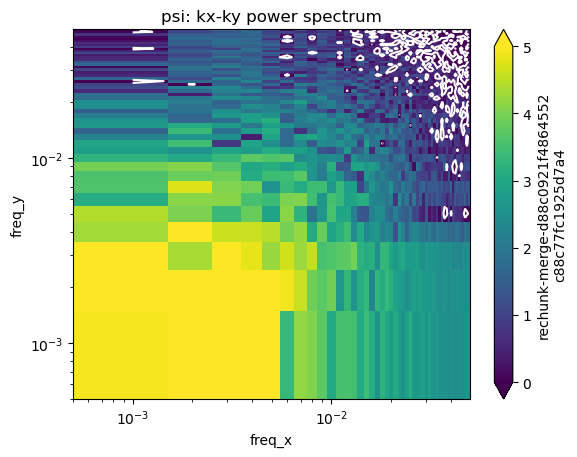

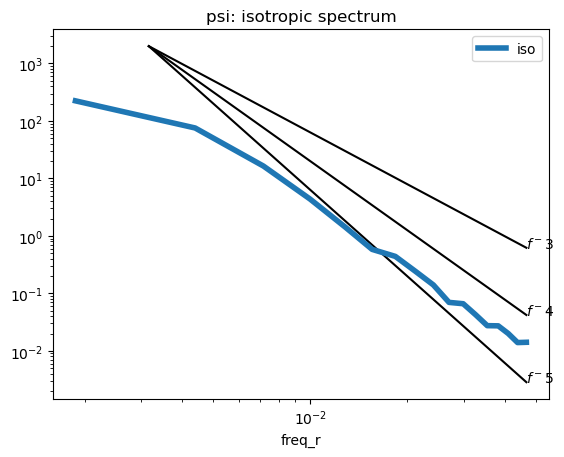

In [17]:
st.plot_spectra(_ds, "psi", yref=2e3, vmin=0, vmax=5, slopes=[-3,-4,-5])

### temporal spectra

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


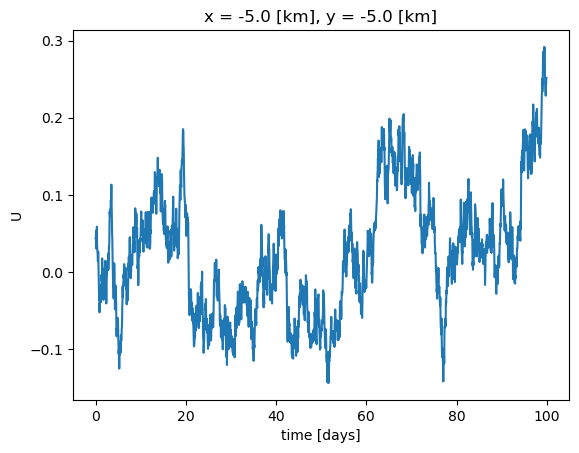

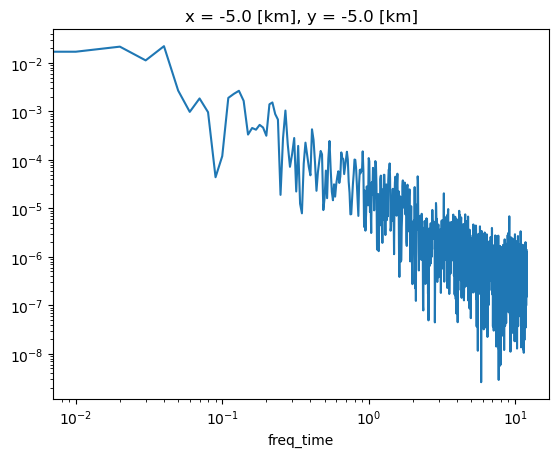

In [18]:
_ds = ds.isel(x=0, y=0).compute()
_ds.U.plot()

E = xrft.power_spectrum(_ds["U"], dim=['time'], detrend='linear', window=True)

fig, ax = plt.subplots(1,1)
E.plot()
ax.set_xscale("log")
ax.set_yscale("log")